# EPPE is short for 'EnergyPLAN Power Flow'
## It attempts to perform power flow optimization based on outputs from EnergyPLAN.
## It leans heavily on some packages, namely gurobi, networkx, pandas.

In [1]:
from __future__ import print_function, division
import os
import pandas as pd
import numpy as np
import gurobipy as gb
import timeit
import networkx as nx
from vresutils import timer
import matplotlib.pyplot as plt
%matplotlib inline

## The following function drops superfluous data points, to avoid warning from Gurobi

In [2]:
def drop_duplicates_from_index(self,keep='first',inplace=False):
    """Return self with duplicate indices removed
    Parameters
    ----------
    keep : {'first_last', first', 'last', False}, default 'first'
        - ``first_last`` : Drop duplicates except for the first and the last occurence
        - otherwise default 'drop_duplicates' behaviour.
    """
    if keep=='first_last':
        result = self[np.logical_not(self.index.duplicated(keep='first')) | np.logical_not(self.index.duplicated(keep='last'))]
    else:
        result = self[np.logical_not(self.index.duplicated(keep=keep))]
    if inplace:
        return self._update_inplace(result)
    else:
        return result
pd.Series.drop_duplicates_from_index = drop_duplicates_from_index

## Load data, calculate incidence matrix and PTDF matrix

In [3]:
# load graph data
nodes = pd.read_csv("data/graph/nodes.csv",header=None,squeeze=True).values
edges = pd.read_csv("data/graph/edges.csv",header=None).values
network = nx.Graph()
network.add_nodes_from(nodes)
network.add_edges_from(edges)
nodes = network.nodes()
edges = network.edges()
# assume link susceptances are equal
link_susceptances = np.ones(len(network.edges()))

# the dimension of incidence matrix is n*l
K = (-nx.incidence_matrix(network,oriented=True)).toarray()
O = np.diag(link_susceptances)
B_inverse = np.linalg.pinv((K.dot(O)).dot(K.T))
H = (O.dot(K.T)).dot(B_inverse)
H[abs(H)<1e-13]=0

# load Cost-Balancing data from EnergyPLAN
CB = {}
for n in nodes:
    df = pd.read_csv("data/cost_blancing/{}.csv".format(n),index_col=0,sep=',')
    df.columns = pd.to_numeric(df.columns.values)
    # convert from MWh to GWh
    CB[n] = df/1e3
T = CB[n].index.values

## Perform the flow optimization for each time step independently, and store the result in a pandas dataframe

In [4]:
%%time
T = np.arange(1,1+24*60)
# T = [23]
times=pd.DataFrame()
start_all = timeit.default_timer()
results = pd.DataFrame()
epsilon = 1e-2
INF = gb.GRB.INFINITY
Fl_b = 1.
pp = CB[nodes[0]].columns.values.tolist()


for t in T:
    start = timeit.default_timer()
    # initialize the gurobi model
    m = gb.Model()

    # create the variable called total flow, positive indicates export and negative corresponds to import
    fl_t = [m.addVar(lb=-Fl_b,ub=Fl_b,name='link {}-{}'.format(bus0,bus1)) for bus0,bus1 in edges]
    Obj = gb.QuadExpr()
    Obj.addTerms(np.repeat(epsilon,len(edges)),fl_t,fl_t)

    # add fl_t^2 to the objective function, weighted by epsilon
    m.setObjective(expr=Obj)

    b = {}
    p = {}
    lbs =[]
    for n in nodes:
        b[n] = CB[n].loc[t,:].values.tolist()
        lbs.append(b[n][0])
        a = pd.Series(index=b[n],data=pp)
        a = a.drop_duplicates_from_index(keep='first_last')
        a.sort_index(inplace=True)
        b[n] = a.index.values
        p[n] = a.values

    # create the variable called Response
    R = [m.addVar(lb=lb, name='R {}'.format(node)) for node,lb in zip(nodes,lbs)]
    m.update()

    # add piecewise linear objective function, 
    [m.setPWLObj(R[nn],b[node],p[node]*(b[node]-b[node][0])) for nn,node in enumerate(nodes)]


    # add two more variables, namely injection and curtailment
    P = [m.addVar(lb=-INF, name='P {}'.format(node)) for node in nodes]
    C = [m.addVar(lb=0., name='C {}'.format(node)) for node in nodes]
    m.update()

    # R = P+C
    [m.addConstr(R[nn]-P[nn]-C[nn] == 0) for nn in range(len(nodes))]

    # F = H*P
    [m.addConstr(fl_t[ll]-gb.LinExpr(H[ll],P) == 0) for ll in range(len(edges))]
    m.addConstr(gb.quicksum(P) == 0)
    
#     for nn,node in enumerate(nodes):
#         m.addConstr(P[nn] - (
#             gb.quicksum([fl_t[ll] for ll,edge in enumerate(edges) if edge[0]==node]) +
#             gb.quicksum([-fl_t[ll] for ll,edge in enumerate(edges) if edge[1]==node])
#             ) == 0 ,'balance-{}'.format(node))

    m.setParam('OutputFlag', 0)
    m.optimize()

    # store the result into a dataframe
    d = {}
    for v in m.getVars():
        d[v.VarName] = v.X
    df = pd.DataFrame([d],columns=d.keys().sort())
    results = pd.concat([results,df])
    times.at[t,'all'] = timeit.default_timer() - start
#     print(m.ObjVal)
results.index=T
times_quad = times.copy().squeeze().rename('Quadratic')

CPU times: user 1min 25s, sys: 384 ms, total: 1min 26s
Wall time: 1min 7s


In [5]:
m.ObjVal

175.52815785575055

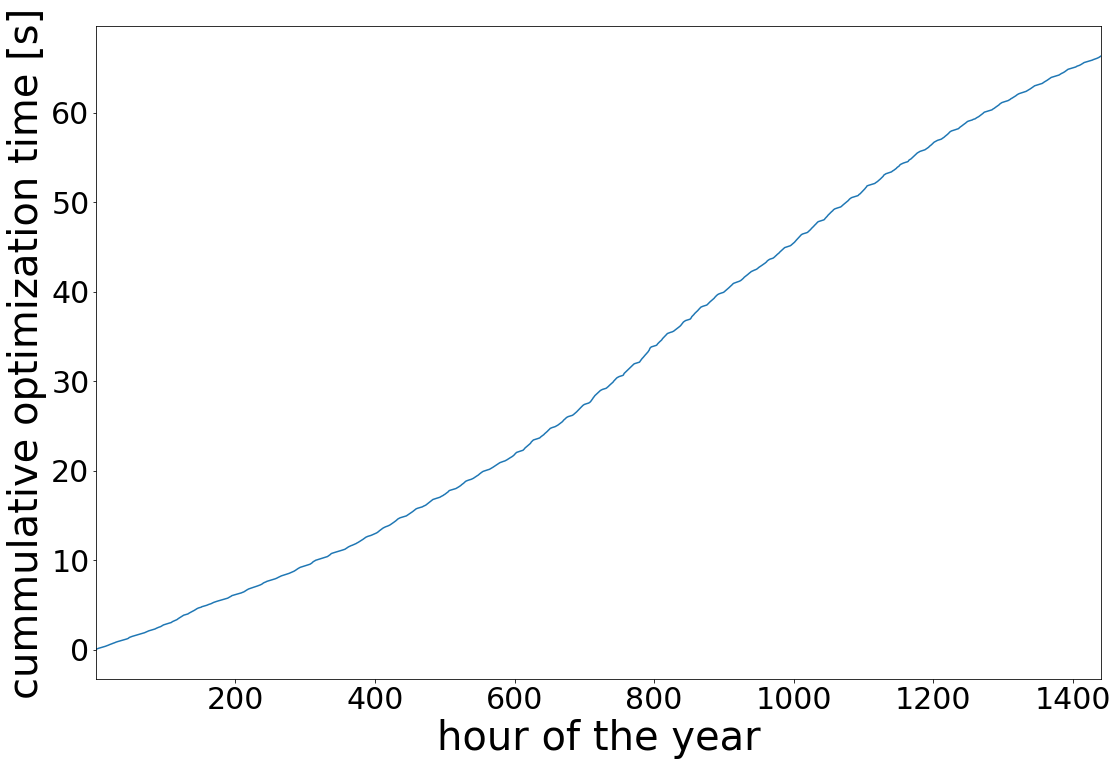

In [6]:
fonts=40
tick=30
linewidth=4
fig,ax = plt.subplots()
fig.set_size_inches(18,12)
times_quad.cumsum().plot(ax=ax)#,marker='s'
ax.set_xlabel('hour of the year',fontsize=fonts)
ax.set_ylabel('cummulative optimization time [s]',fontsize=fonts)
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)
fig.savefig('./231117_CHP_workshop_slides/figures/cummulative_timer.pdf',dpi=500)

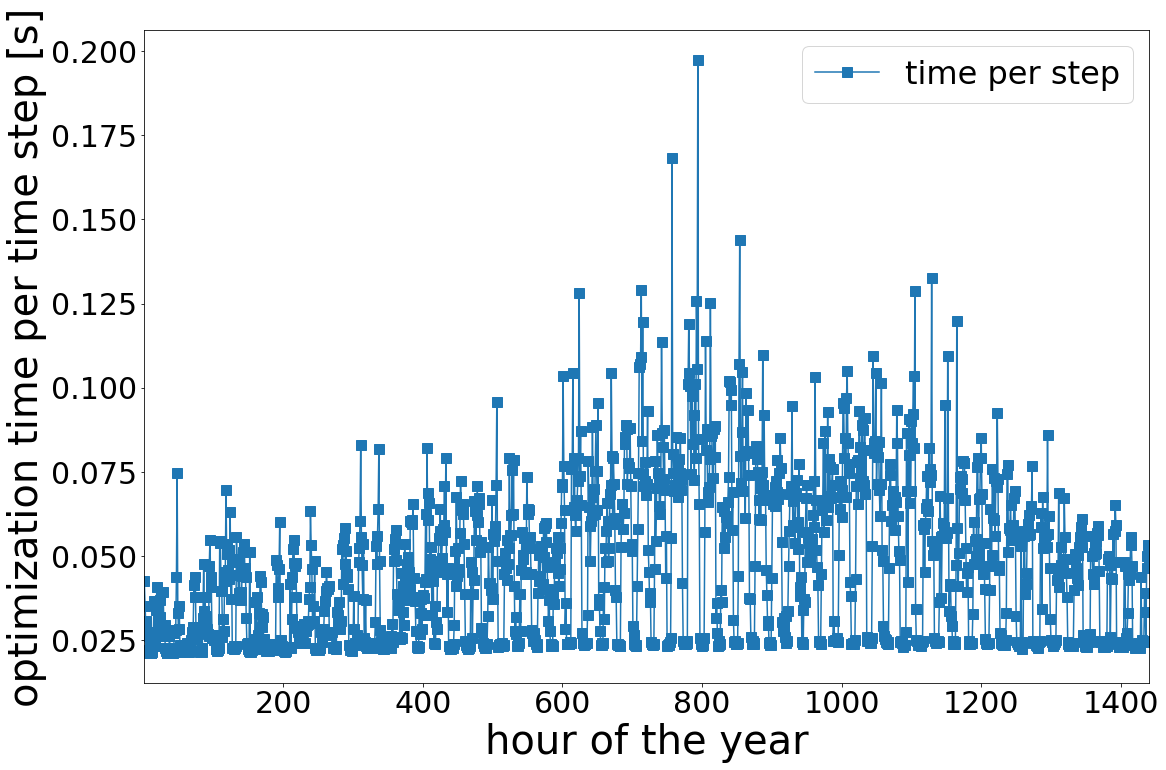

In [9]:
fonts=40
tick=30
linewidth=4
fig,ax = plt.subplots()
fig.set_size_inches(18,12)
times_quad.plot(ax=ax,marker='s',markersize=10)
ax.legend(['time per step'],fontsize=fonts*0.8)
ax.set_xlabel('hour of the year',fontsize=fonts)
ax.set_ylabel('optimization time per time step [s]',fontsize=fonts)
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)
fig.savefig('./231117_CHP_workshop_slides/figures/step_timer.pdf',dpi=500)